- Build PPMI vectors
- Visualize PPMI vectors to verify correctness
- Use logistic regression + PPMI vectors on IMDB dataset


In [1]:
from collections import defaultdict, Counter
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt
import evaluate
from utils import get_vocab
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

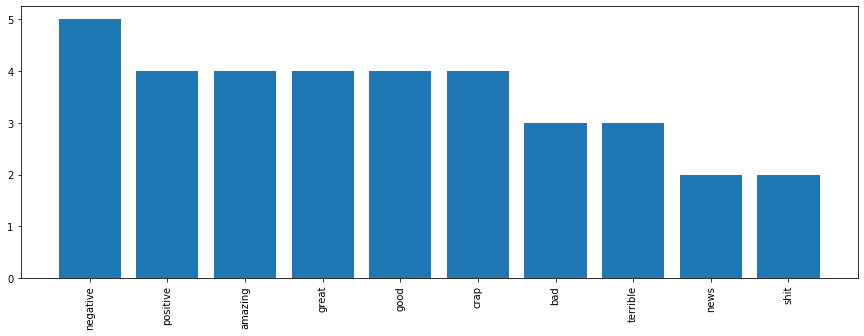

In [2]:
class PPMIClassifier:
    def __init__(self, vocab_size, word2int, num_classes, int2word, window_size) -> None:
        self.co_occurence_matrix = np.zeros((vocab_size, vocab_size))
        self.ppmi_matrix = np.zeros((vocab_size, vocab_size))
        self.window_size = window_size
        self.word2int = word2int
        self.int2word = int2word
        self.num_classes = num_classes
        self.vocab_size = vocab_size

    def fit(self, X, split=False, logging=False, logging_interval=100):
        for k, x in enumerate(X):
            if split:
                x = x.split(' ')
            if k % logging_interval == 0 and logging:
                print(f'counted {k} out of {len(X)}')
            for i in range(len(x)):
                for j in range(i-self.window_size,i+self.window_size+1):
                    if i > 0 and j > 0 and j < len(x) and i != j:
                        self.co_occurence_matrix[self.word2int[x[i]]][self.word2int[x[j]]] += 1
        
        total_word_count = self.co_occurence_matrix.sum()
        for i in range(1, self.vocab_size):
            if i % logging_interval == 0 and logging:
                print(f'processed {i} out of {self.vocab_size}')
            for j in range(1, self.vocab_size):
                num = self.co_occurence_matrix[i][j] / total_word_count
                den = self.co_occurence_matrix[i].sum() * self.co_occurence_matrix[j].sum() / (total_word_count ** 2)
                pmi = (num + 1e-5) / (den + 1e-5)
                self.ppmi_matrix[i][j] = max(np.log2(pmi), 0)
            self.ppmi_matrix[i] /= (np.sqrt((self.ppmi_matrix[i] * self.ppmi_matrix[i]).sum()) + 1e-5)
    
    def visualize_word(self, word, k=100):
        vector = self.ppmi_matrix[self.word2int[word]]
        top_dimensions = vector.argsort()[::-1][:k]
        top_dimensions = [dim for dim in top_dimensions if dim != 0]
        top_words = [self.int2word[i] for i in top_dimensions]

        plt.bar(top_words, vector[top_dimensions])
        plt.xticks(rotation=90)
        plt.show()
    
    def get_word_similarity(self, word1, word2):
        vec1 = self.ppmi_matrix[self.word2int[word1]]
        vec2 = self.ppmi_matrix[self.word2int[word2]]
        if self.word2int[word1] == 0 or self.word2int[word2] == 0:
            return 0
        return vec1.dot(vec2)


toy_X = [
        ['this', 'is', 'positive', 'amazing', 'great', 'good'],
        ['positive', 'amazing', 'great', 'good'],
        ['positive', 'amazing', 'news', 'great', 'good'],
        ['amazing', 'news', 'positive', 'great', 'good'],
        ['this', 'is','negative','bad', 'terrible', 'shit'],
        ['negative','bad', 'this', 'terrible', 'crap'],
        ['negative', 'shit', 'crap'],
        ['bad', 'negative', 'crap'],
        ['terrible', 'negative', 'this', 'crap']
    ]
toy_Y = [1, 1, 1,1, 0, 0, 0, 0]
toy_vocab, toy_word2int, toy_int2word = get_vocab(toy_X)
toy_ppmi_classifier = PPMIClassifier(vocab_size=len(toy_vocab) + 1, word2int=toy_word2int, num_classes=2, int2word=toy_int2word, window_size=5)
toy_ppmi_classifier.fit(toy_X)


In [3]:
toy_ppmi_classifier.get_word_similarity('negative', 'amazing')

0.0

In [4]:
train_dataset = load_dataset('imdb', split='train')
test_dataset = load_dataset('imdb', split='test')

Reusing dataset imdb (/home/ajrfhp/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
Reusing dataset imdb (/home/ajrfhp/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


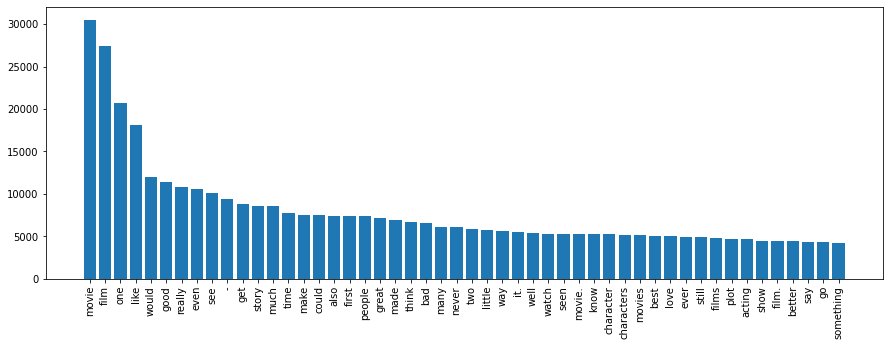

counted 0 out of 25000
counted 1000 out of 25000
counted 2000 out of 25000
counted 3000 out of 25000
counted 4000 out of 25000
counted 5000 out of 25000
counted 6000 out of 25000
counted 7000 out of 25000
counted 8000 out of 25000
counted 9000 out of 25000
counted 10000 out of 25000
counted 11000 out of 25000
counted 12000 out of 25000
counted 13000 out of 25000
counted 14000 out of 25000
counted 15000 out of 25000
counted 16000 out of 25000
counted 17000 out of 25000
counted 18000 out of 25000
counted 19000 out of 25000
counted 20000 out of 25000
counted 21000 out of 25000
counted 22000 out of 25000
counted 23000 out of 25000
counted 24000 out of 25000
processed 1000 out of 4680
processed 2000 out of 4680
processed 3000 out of 4680
processed 4000 out of 4680


In [5]:
vocab, word2int, int2word = get_vocab(train_dataset['text'], split=True, vocab_size=5000, visualize=True)
ppmi_classifier = PPMIClassifier(vocab_size=len(vocab) + 1, word2int=word2int, num_classes=2, int2word=int2word, window_size=3)
ppmi_classifier.fit(train_dataset['text'],split=True, logging=True, logging_interval=1000)

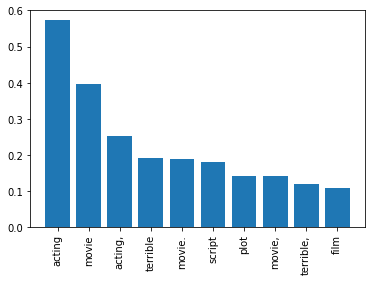

(0.6070821941715573, 0.4605827935016001)

In [6]:
ppmi_classifier.visualize_word('terrible', k = 10)
ppmi_classifier.get_word_similarity('amazing', 'great'), ppmi_classifier.get_word_similarity('great', 'terrible')

- Use PPMI to encode vectors in train and test datasets
- Train logistic regression model on top of encoded vectors
- Get predictions
- Measure accuracy

In [7]:
def get_vectors(X, ppmi_classifier, split=True):
    X_vec = []
    X = X['text']
    for x in X:
        x_vec = np.zeros(ppmi_classifier.vocab_size)
        if split:
            x = x.split(' ')
            for word in x:
                if ppmi_classifier.word2int[word]:
                    x_vec += ppmi_classifier.ppmi_matrix[word2int[word]]
        X_vec.append(x_vec)
    return {"vectors" : np.array(X_vec)}



get_vectors({"text" : ['this is a amazing movie', 'terrible movie']}, ppmi_classifier)['vectors'].shape

(2, 4680)

In [8]:
train_vectors = train_dataset.map(get_vectors, batched=True, fn_kwargs={'ppmi_classifier' : ppmi_classifier}, remove_columns=['text'])
test_vectors = test_dataset.map(get_vectors, batched=True, fn_kwargs={'ppmi_classifier' : ppmi_classifier}, remove_columns=['text'])
train_vectors.set_format('torch')
test_vectors.set_format('torch')

train_dataloader = DataLoader(
    train_vectors, shuffle=True, batch_size=1000,
)
test_dataloader = DataLoader(
    test_vectors, batch_size=1000
)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self, dim=24) -> None:
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(dim, 1)
    
    def forward(self, x):
        return nn.Sigmoid()(self.fc1(x))

model = LogisticRegression(dim=4680)
model.forward(train_vectors['vectors'][900:1200]).squeeze(dim=-1).max()

tensor(0.7445, grad_fn=<MaxBackward1>)

In [11]:
def train(model, train_dataloader, optmizer, logging_interval=100, epochs=10):
    model.train()
    for epoch in range(epochs):
        for i, batch in enumerate(train_dataloader):
            inputs, outputs = batch['vectors'], batch['label']
            predictions = model.forward(inputs).squeeze(dim=-1)
            loss = nn.functional.binary_cross_entropy(predictions, outputs.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i%logging_interval == 0:
                print(epoch, i, loss)

def eval(model, test_dataloder, logging_interval=100):
    correct, total = 0, 0
    model.eval()
    for i, batch in enumerate(test_dataloder):
        inputs, outputs = batch['vectors'], batch['label']
        predictions = model.forward(inputs).squeeze(dim=-1)
        predictions[predictions.le(0.5)] = 0
        predictions[predictions.ge(0.5)] = 1
        correct += len(predictions[predictions == outputs])
        total += len(outputs)
        if i > 10:
            break
    print(correct/total)

model = LogisticRegression(dim=4680)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
eval(model, test_dataloader)
train(model, train_dataloader, optimizer)
eval(model, test_dataloader)

0.22558333333333333
0 0 tensor(0.7061, grad_fn=<BinaryCrossEntropyBackward0>)
1 0 tensor(0.5698, grad_fn=<BinaryCrossEntropyBackward0>)
2 0 tensor(0.5120, grad_fn=<BinaryCrossEntropyBackward0>)
3 0 tensor(0.5006, grad_fn=<BinaryCrossEntropyBackward0>)
4 0 tensor(0.4674, grad_fn=<BinaryCrossEntropyBackward0>)
5 0 tensor(0.4675, grad_fn=<BinaryCrossEntropyBackward0>)
6 0 tensor(0.4480, grad_fn=<BinaryCrossEntropyBackward0>)
7 0 tensor(0.4284, grad_fn=<BinaryCrossEntropyBackward0>)
8 0 tensor(0.4265, grad_fn=<BinaryCrossEntropyBackward0>)
9 0 tensor(0.4137, grad_fn=<BinaryCrossEntropyBackward0>)
0.8045833333333333


In [21]:
def predict(sentence, ppmi_classifier, model):
    sentence = {
        'text' : [sentence]
    }
    vector = get_vectors(sentence, ppmi_classifier)['vectors']
    prediction = model.forward(torch.tensor(vector).float())
    print(prediction.ge(0.5)[0][0])


In [24]:
predict('terrible crap acting', ppmi_classifier, model)

tensor(False)


In [25]:
predict('love this movie', ppmi_classifier, model)

tensor(True)


In [26]:
predict('incredible movie', ppmi_classifier, model)

tensor(True)


In [27]:
predict('crappy shit', ppmi_classifier, model)

tensor(False)
